In [1]:
!pip install tqdm

from tqdm import tqdm
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
tf.set_random_seed(10)
np.random.seed(10)

In [3]:
MNIST_DATASETS = tf.contrib.learn.datasets.load_dataset("mnist")
fashion_dataset = tf.keras.datasets.fashion_mnist.load_data()

scl = StandardScaler()
min_scl = MinMaxScaler()

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-u

In [0]:
def WeightsVariable(shape, num = 0):
    name = 'weights' + str(num)
    return tf.get_variable(name=name, initializer=tf.initializers.glorot_uniform(),shape=shape) #tf.nn tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))
  
def Conv2d(x, W, B, stride = 1, padding = 'VALID', activation_fun = True):
    filter_size = W.get_shape().as_list()
    pad_size = filter_size[0] // 2
    pad_mat = np.array([[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]])
    
    x = tf.pad(x, pad_mat)
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding = padding)
    x = tf.nn.bias_add(x, B)
    
    if(activation_fun == True):
        return tf.nn.relu(x)
    else:
        return x

def MaxPool2d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'VALID')  


In [0]:
def network(images, channels = 1, input_channel = 3, output_shape = 3):
#     num_c = [256, 128, 64, 32, 16, 8, 4]
    filter_size = 3
    num_i = 0
    with tf.name_scope('conv0'):
        weights = WeightsVariable([filter_size, filter_size, input_channel, num_c[num_i]], num = num_i)
        biases = BiasVariable(num_c[num_i])
        fc1 = Conv2d(images, weights, biases)
    num_i += 1
    
    for i in range(len(num_c)-1):
        name = 'conv1' + str(i+2)
        
        if num_c[num_i] == -1:
            fc1 = MaxPool2d(fc1)
        else:
            prev_l = num_c[num_i - 1]
            if num_c[num_i - 1] == -1:
                prev_l = num_c[num_i - 2]
            with tf.name_scope(name):
                weights = WeightsVariable([filter_size, filter_size, prev_l, num_c[num_i]], num = num_i)
                biases = BiasVariable(num_c[num_i])
                fc1 = Conv2d(fc1, weights, biases)
        num_i += 1
        
    with tf.name_scope('flatten'):
        flat = tf.layers.flatten(fc1)
        
    input_flat_shape = np.int32(flat.shape[1])
    num_f = [input_flat_shape, 64, 10]
    num_if = 1

    with tf.name_scope('fc1'):
        weights = WeightsVariable([num_f[num_if-1], num_f[num_if]], num = num_i)
        biases = BiasVariable(num_f[num_if])
        fc1 = tf.nn.relu(tf.matmul(flat, weights) + biases)
        
    num_if+=1
    num_i += 1
    
    with tf.name_scope('fc2'):
        weights = WeightsVariable([num_f[num_if-1], num_f[num_if]], num = num_i)
        biases = BiasVariable(num_f[num_if])
        fc2 = tf.matmul(fc1, weights) + biases
        
    return fc2

In [0]:
def loss_metrics(logits, labels, output_shape=1):
    logits = logits
    if output_shape == 1:
      cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
      
    else:
      cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    learning_rate = tf.train.exponential_decay(STARTER_LR, 
                                               global_step = global_step, 
                                               decay_steps = 200, 
                                               decay_rate = 0.6, 
                                               staircase = True)
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels, output_shape = 1):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels, output_shape = 1):
  
    if(output_shape == 1):
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32), tf.cast(labels, tf.float32))
        
    else:
        correct_prediction = tf.equal(tf.argmax(logits, 1),  tf.cast(labels, tf.int64), name='correct_pred')
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, input_shape=None, output_shape=1):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, input_shape[0], input_shape[1], input_shape[2]))
    if output_shape == 1:
      label_placeholder = tf.placeholder(tf.float32, shape = (None))
    else:
      label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y, input_shape=None, output_shape=1, test_data = None):
    if test_data is not None:
        x_test, y_test = test_data[0], test_data[1]
        x_train = x
        y_train = y
        
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
        
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE, input_shape=input_shape, output_shape = output_shape)
        logits = network(images_pl, input_channel=input_shape[2], output_shape=output_shape)
        
        print("Logits Calculated Successfully")
        
        loss = loss_metrics(logits = logits, labels = labels_pl, output_shape = output_shape)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl, output_shape = output_shape)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []

            for i in tqdm(np.arange(0, len(x_train) - 1, BATCH_SIZE)):
                images_feed = x_train[i : i + BATCH_SIZE]
                labels_feed = y_train[i : i + BATCH_SIZE]
                feed_dict = { images_pl: images_feed, labels_pl: labels_feed }
                _ = sess.run([train_op], feed_dict = feed_dict)

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            images_feed = x_train[:10000]
            labels_feed = y_train[:10000]

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('\nLoss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [12]:
train, test = fashion_dataset[0], fashion_dataset[1]
x = train[0]
y = train[1]

x = np.reshape(x, [-1, 28, 28 ,1])
x_test = test[0][:2000]
y_test = test[1][:2000]

test = []
test.append(np.reshape(x_test, [-1, 28, 28 ,1]))
test.append(y_test)
# x = min_scl.fit_transform(x)
shape = [28, 28, 1]
x = np.asarray(x, dtype = np.float32)
y = np.asarray(y, dtype = np.float32)

STARTER_LR = 5e-5
BATCH_SIZE = 64
MAX_STEPS = 30
num_c = [512, 256, -1, 128, -1, 64]

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(x, y, input_shape=shape, output_shape=12, test_data = test)

Logits Calculated Successfully


100%|██████████| 938/938 [01:28<00:00, 10.60it/s]


ResourceExhaustedError: ignored

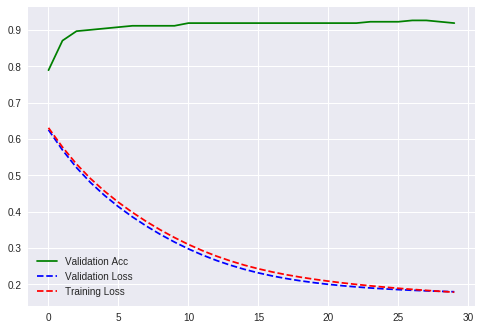

In [50]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b--', label="Validation Loss")
plt.plot(train_plot, "r--", label='Training Loss')
plt.legend(loc='best')

In [13]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

NameError: ignored

In [83]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    